# YouTube ratings

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data inspection

In [12]:
youtube = pd.read_csv('youtube.csv')
youtube.head()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


In [13]:
youtube.isnull().sum()

Rank             0
Grade            0
Channel name     0
Video Uploads    0
Subscribers      0
Video views      0
dtype: int64

No missing values detected.

In [14]:
# Renaming the youtube dataframe columns to remove whitespace headings
youtube.rename(columns={'Channel name':'Channel_name',
                       'Video Uploads': 'Video_Uploads',
                       'Video views': 'Video_views'},
              inplace = True)

In [15]:
youtube.dtypes

Rank             object
Grade            object
Channel_name     object
Video_Uploads    object
Subscribers      object
Video_views       int64
dtype: object

Video Uploads and Subscribers should be integer variables.

In [16]:
#Upon inspection it was found that missing 'Video Upload' values were in the form of "--"
(youtube["Video_Uploads"] == '--').sum()

6

In [17]:
youtube["Video_Uploads"] = youtube["Video_Uploads"].replace('--', np.nan)
#youtube["Video Uploads"] = youtube["Video Uploads"].astype('int64')

In [18]:
#Upon inspection it was found that missing 'Subscriber' values were in the form of "-- "
(youtube["Subscribers"] == '-- ').sum()

387

In [19]:
youtube["Subscribers"] = youtube["Subscribers"].replace('-- ', np.nan)

Missing data is present in the dataframe. 6 values missing from Video_Uploads and 387 values missing from Subscribers. I will need to determine if I can apply imputation.

In [20]:
youtube.Grade.unique()

array(['A++ ', 'A+ ', 'A ', '\xa0 ', 'A- ', 'B+ '], dtype=object)

In [21]:
# What is \xa0 character?
(youtube.Grade == '\xa0 ').sum()

6

In [22]:
youtube[youtube.Grade == '\xa0 ']

,Rank,Grade,Channel_name,Video_Uploads,Subscribers,Video_views
267,268th,,MidnightXChannel,NaN,NaN,190256974
517,518th,,Dusama Pets TV,NaN,NaN,91601494
2323,"2,324th",,Random,NaN,12275,17897584
3072,"3,073rd",,Boram Tube Toy Shcool [보람튜브…,NaN,726527,205555289
3247,"3,248th",,atheer sultan,NaN,NaN,79663674
4898,"4,899th",,ExzoticSlice,NaN,99785,9745292


'\xa0 ' are missing grades. It is noted that these missing values correspond to all missing values in the Video_Uploads column. It is also noted that these observations are not of significant rank and would therefore not affect an analysis on the data. Since 'Grade' is the response variable these observations could be dropped without losing further information. There are only 6 of these observations which implies that only a small fraction of the data (6/5000 = 0.12%) will be removed. By dropping these observations, no missing data or imputation decision will need to be made on the "Video_Uploads" column. Focus can be shifted to dealing with missing values in the 'Subscribers' column.

In [23]:
# Rows to drop
drop_index = np.array(youtube[youtube.Grade == '\xa0 '].index)

In [24]:
# Drop missing 'Grade' observations and reset index
youtube = youtube.drop(drop_index).reset_index()

In [25]:
#Convert Subscribers and Video_Uploads to numeric
youtube.Subscribers = pd.to_numeric(youtube.Subscribers)
youtube.Video_Uploads = pd.to_numeric(youtube.Video_Uploads)

## EDA and Imputation

The Rank variable needs to be adjusted after dropping the Grade-missing observations. This variable should be numeric so that it can be recognized as a numeric rank. I.e. a computer knows that 2 < 3 but it does not know 2nd from 3rd. Also, this value being numeric allows for creating more informative plots. 

In [26]:
# Create the new rank variable and add it to youtube. 
new_rank = np.array(youtube.index)
youtube["new_rank"] = new_rank + 1 # indexing starts at 0

### Do Subscribers influence Grade?

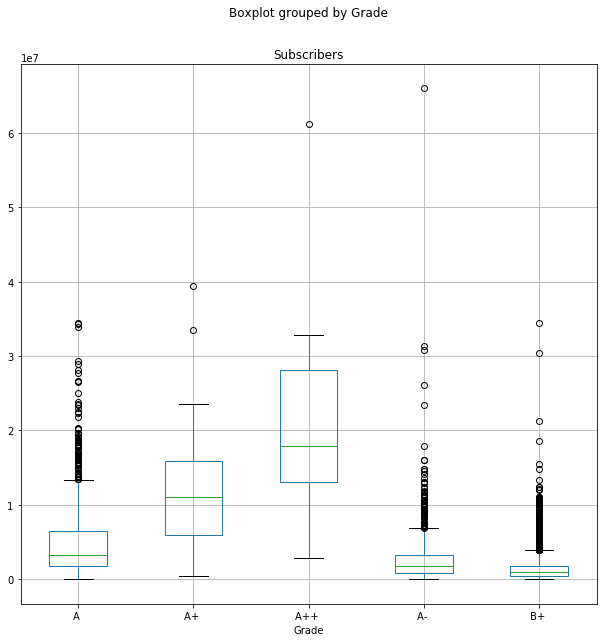

In [27]:
youtube.boxplot('Subscribers', 'Grade', figsize=(10,10))
plt.show()

From the above plot it appears that the number of Subscribers do influence Grade. The higher the mean number of subscribers, the higher the grade. An interesting point to note is that the Subscribers data generally seems skewed to the right - there are a lot of boxplot outliers above the mean. It might be worth looking at what drives Subscribers before making a decision on imputation.

### Correlation matrix

In [62]:
youtube.corr()

,index,Video_Uploads,Subscribers,Video_views,new_rank
index,1.000000,-0.069139,-0.383329,-0.390397,1.000000
Video_Uploads,-0.069139,1.000000,0.011362,0.092436,-0.069133
Subscribers,-0.383329,0.011362,1.000000,0.791241,-0.383308
Video_views,-0.390397,0.092436,0.791241,1.000000,-0.390372
new_rank,1.000000,-0.069133,-0.383308,-0.390372,1.000000


#### Points on the correlation matrix:
- Surprisingly, Video_Uploads does not have a very significant correlation with a channel's rank.
- Rank has a negative correlation with Subscribers and with Video_views. 
- Points 1 and 2 are suggestive that a channel's success is not determined by the number of videos it uploads but rather the content of its videos and how many people watch them. 
- On point 2 - Subscribers is highly correlated with Video_views. Further investigation into this relationship should help imputation.
- Visualizations of the above correlation matrix have been constructed below under the heading "Additional Visualizations"

### The relationship between Subscribers and Video_views

C:\Users\Grant\Anaconda3_5\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


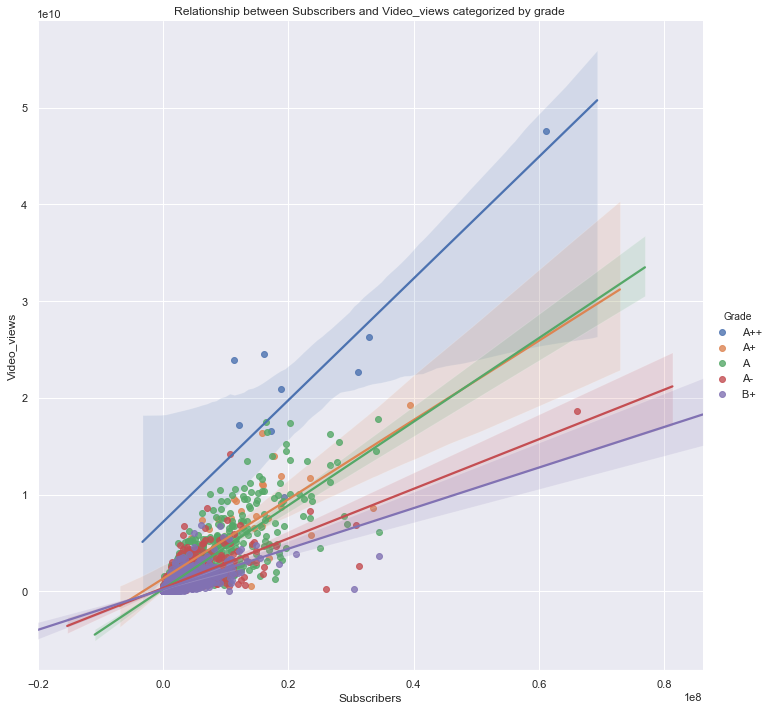

In [189]:
# Using seaborn
sns.lmplot("Subscribers", "Video_views", data=youtube, hue='Grade', height=10, aspect=1)
ax = plt.gca()
ax.set_title("Relationship between Subscribers and Video_views categorized by grade")
plt.show()

Video_views and Subscribers have a positively linear relationship. It is evident for all ranks that Video_views increases with the number of subscribers. For higher grades, this effect is more prominent. The linear relationship between Subscribers and the number of video views for various grades can be used to model the imputation for missing subscriber values (linear regression).

## Imputation using Linear Regression

#### Linearly regressing Subscribers using Grade and Video_views as independent variables.

Considering the factors for determining the number of Subscribers have already been identified and that the purpose for this regression is to impute values rather than create a functional model, a train-test split and model validation will not be required. The full dataset, where values are not missing, will be used.

In [114]:
# Subset dataset which does not include missing values 
regress_data = youtube[["Subscribers", "Grade", "Video_views"]].dropna()
regress_data.shape

(4610, 3)

In [119]:
# Separating response and independent variables
X = regress_data.iloc[:,1:7] # independent vars
y = regress_data["Subscribers"] # response var

In [115]:
# Create dummy variables for Grades column
dummyCols = pd.get_dummies(regress_data.Grade)
regress_data = regress_data.join(dummyCols)
del regress_data["Grade"]
regress_data.head()

,Subscribers,Video_views,A,A+,A++,A-,B+
0,18752951.0,20869786591,0,0,1,0,0
1,61196302.0,47548839843,0,0,1,0,0
2,19238251.0,9793305082,0,0,1,0,0
3,31180559.0,22675948293,0,0,1,0,0
4,32852346.0,26273668433,0,0,1,0,0


In [120]:
# Performing the linear regression with sci-kit learn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [126]:
# Subsetting dataset of all missing values
missing_data = youtube[youtube.Subscribers.isnull()]
missing_data.head()

,index,Rank,Grade,Channel_name,Video_Uploads,Subscribers,Video_views,new_rank
17,17,18th,A+,Vlad and Nikita,53,NaN,1428274554,18
108,108,109th,A,BIGFUN,373,NaN,941376171,109
115,115,116th,A,Bee Kids Games - Children TV,740,NaN,414535723,116
142,142,143rd,A,ChiChi TV Siêu Nhân,421,NaN,2600394871,143
143,143,144th,A,MusicTalentNow,1487,NaN,3252752212,144


In [158]:
# Index of observations with missing data for later use
missing_index = np.array(missing_data.index)

In [129]:
# Setting up the data on which to derive predictions from
prediction_data = missing_data[["Grade", "Video_views"]]
dummyCols = pd.get_dummies(prediction_data.Grade)
prediction_data = prediction_data.join(dummyCols)
del prediction_data["Grade"]
prediction_data.head()

,Video_views,A,A+,A-,B+
17,1428274554,0,1,0,0
108,941376171,1,0,0,0
115,414535723,1,0,0,0
142,2600394871,1,0,0,0
143,3252752212,1,0,0,0


In [148]:
# Need an A++ column of zeroes
prediction_data['A++ '] = np.zeros(shape=len(prediction_data), dtype = 'uint8')
prediction_data = prediction_data[["Video_views", "A ", "A+ ", "A++ ", "A- ", "B+ "]] # order it correctly
prediction_data.head()

,Video_views,A,A+,A++,A-,B+
17,1428274554,0,1,0,0,0
108,941376171,1,0,0,0,0
115,414535723,1,0,0,0,0
142,2600394871,1,0,0,0,0
143,3252752212,1,0,0,0,0


In [151]:
# Predict
imputations = lm.predict(prediction_data)
imputations

array([4244945.87230997, 2650319.47622347, 1818793.61718417,
       5268791.45368211, 6298423.86029569, 3196209.29575239,
       1332300.44704611, 1776273.36293994, 3649843.8460775 ,
       1301073.00009136, 3971373.01505643, 1305176.08838223,
       1308056.53450218, 2146449.74897023, 1956716.70418487,
       1978499.27134385, 4632404.49991131, 1286622.45220464,
       1164933.50171241, 2298304.18412361, 1295245.16158534,
       2562796.88314935, 2857129.03050232, 1164521.75281889,
       1288199.37958423, 1488524.53393071, 1276077.3246669 ,
       1748907.44467265, 1976180.27358232, 2082958.26119732,
       1463286.15935164, 3041739.4216902 , 2590798.60943735,
       1425405.52472768, 1243512.89846533, 1692616.09600511,
       1485157.01016292, 1311904.52588947, 1266212.83118025,
       1234226.39892622, 1268231.02688037, 1270304.14673916,
       1738434.20513905, 2052667.98620867, 1922143.94839762,
       1243965.35553728, 1250228.12065085, 4397819.78327466,
       1512859.37855759,

In [165]:
# Feed these back into the dataframe
youtube.iloc[missing_index, 5] = imputations

In [166]:
# Check missing values are now filled
youtube.isnull().sum()

index            0
Rank             0
Grade            0
Channel_name     0
Video_Uploads    0
Subscribers      0
Video_views      0
new_rank         0
dtype: int64

In [167]:
youtube.shape # all rows accounted for

(4994, 8)

## Additional Visualizations

### Effect of Subscribers on Rank

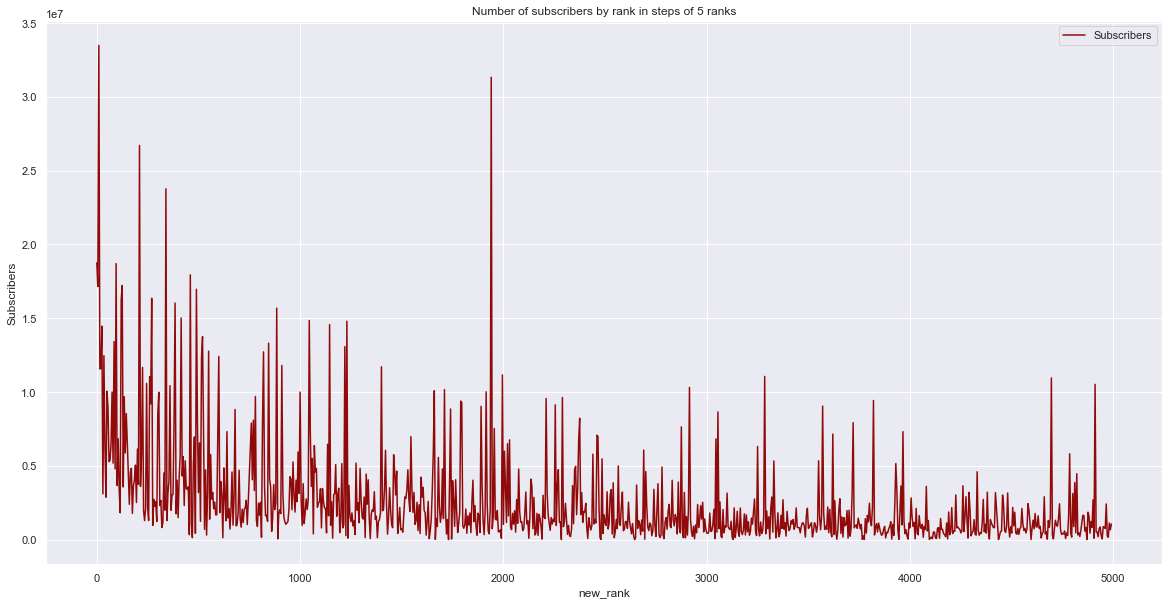

In [199]:
youtube[0:5000:5].plot("new_rank", "Subscribers", figsize=(20,10), color="#910a0a")
plt.ylabel("Subscribers")
plt.title("Number of subscribers by rank in steps of 5 ranks")
plt.show()

The above plot charts the number of subscribers for each rank where only every 5th rank is plotted. This is done to 'thin' the plot out a bit to get a sense of the overall picture. The negative correlation between the two variables is apparent by the overall downward slope.

### Effect of Video_Views on Rank

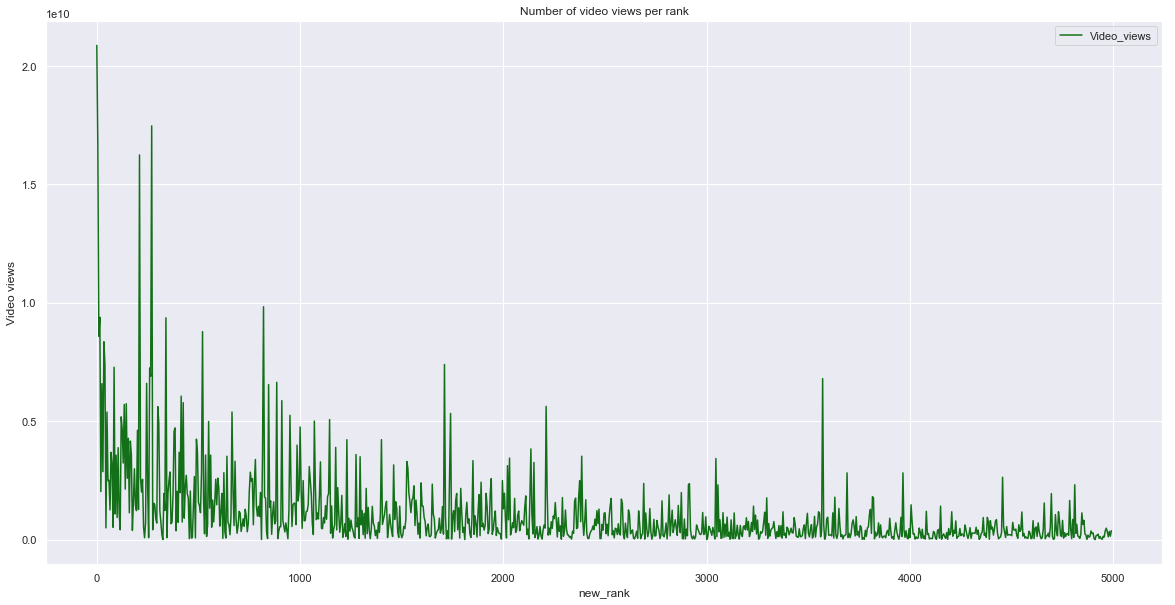

In [203]:
youtube[0:5000:5].plot("new_rank", "Video_views", figsize=(20,10), color="#137019")
plt.ylabel("Video views")
plt.title("Number of video views per rank")
plt.show()

The above plot charts the number of video uploads for each rank where only every 5th rank is plotted. The same technique as applied to the Subscribers-rank plot was applied get a sense of the overall picture. The two plots look very similar as explained by the very similar correlation figures in the correlation matrix.

### Effect of Video_Uploads on Rank

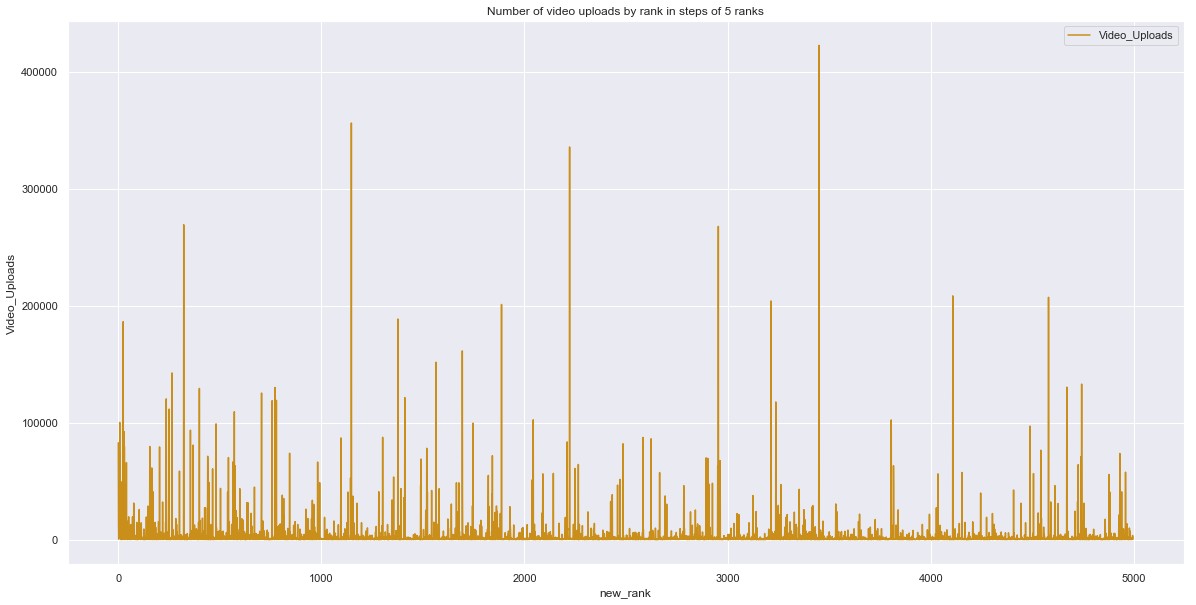

In [200]:
youtube.plot("new_rank", "Video_Uploads", figsize=(20,10), color='#c98f1a')
plt.ylabel("Video_Uploads")
plt.title("Number of video uploads by rank in steps of 5 ranks")
plt.show()

The density of the plot shows that there are more channels at the higher end (top ranks) with more video uploads than at the bottom ranks. This is confirmed by the mean upload per Grade.

In [206]:
grouped_grades = youtube.groupby("Grade")["Video_Uploads"].mean()
grouped_grades

Grade
A        5357.026999
A+      16547.926829
A++     37450.700000
A-       4136.514648
B+       2985.988160
Name: Video_Uploads, dtype: float64

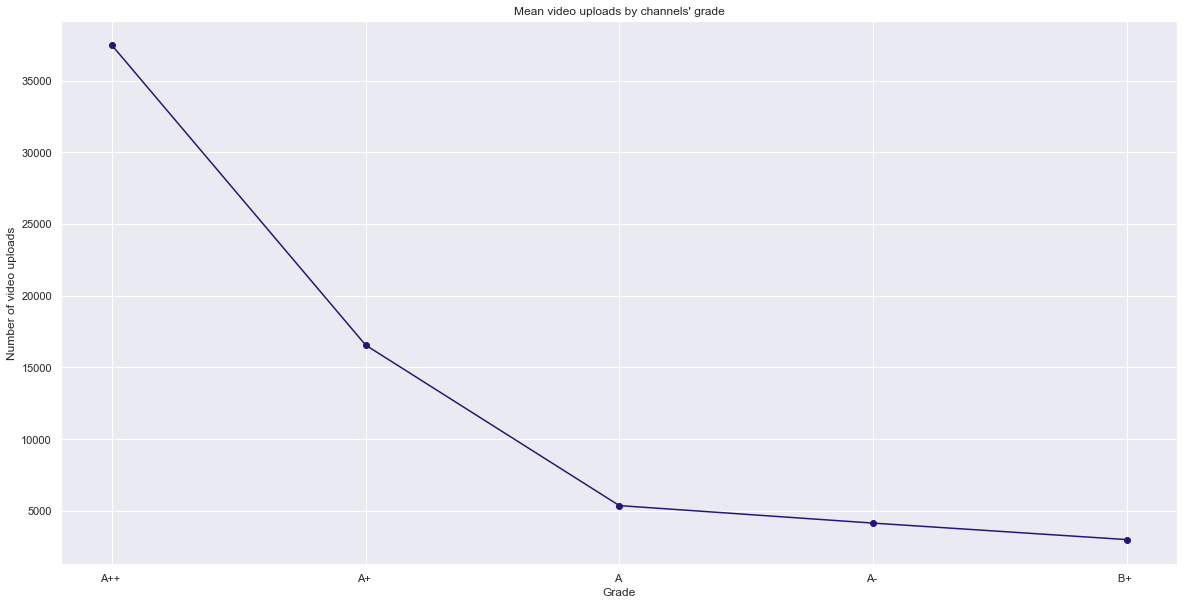

In [217]:
plt.plot(grouped_grades.sort_values(ascending = False), color="#2a1377", marker="o")
plt.title("Mean video uploads by channels' grade")
plt.ylabel("Number of video uploads")
plt.xlabel("Grade")
plt.show()

Earlier in the correlation matrix, it showed that Video_Uploads was not significantly correlated to rank. I had assumed that rank was an indication of grade. Upon plotting it visually and calculating a grouped average by grade - it suggests that Video_Uploads does play a bigger role than initially anticipated with respect to the grade received by the channel.